In [1]:
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer

In [2]:
!pip install LiveLossPlot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(seed)

# flatten 28*28 images to a 784 vector for each image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])

# load data
trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)

# create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

# define baseline model
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out


In [14]:
# define the loss function and the optimiser
device = "cuda:0" if torch.cuda.is_available() else "cpu"

train_loss_final = []
train_accuracy_final = []
test_loss_final = []
test_accuracy_final = []

for j in [2000, 20000, 200000]:
  model = BaselineModel(784, j, 10).to(device)

  loss_function = nn.CrossEntropyLoss()
  optimiser = optim.Adam(model.parameters())

  train_loss = torch.empty(10)
  train_acc = torch.empty(10)

  test_loss = torch.empty(10)
  test_acc = torch.empty(10)

  # the epoch loop
  for epoch in range(10):
      train_loss_val = 0.0
      accuracy_train = 0.0
      for data in trainloader:
          model.train()
          # get the inputs
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          optimiser.zero_grad()

          outputs = model(inputs)
          loss = loss_function(outputs, labels)
          loss.backward()
          optimiser.step()

          train_loss_val += loss.item()
          
          model.eval()
          with torch.no_grad():
              outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          accuracy_train = accuracy_train + (preds == labels).sum()
          

      accuracy_train = accuracy_train / len(trainloader.dataset)
      train_loss_val /= len(trainloader)

      train_loss[epoch] = train_loss_val
      train_acc[epoch] = accuracy_train

      
      model.eval()
      with torch.no_grad():
          test_accuracy = 0.0
          test_loss_val = 0.0
          for data in testloader:
              inputs, labels = data
              inputs, labels = inputs.to(device), labels.to(device)

              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
          
              loss = F.nll_loss(torch.log(outputs), labels)

              test_accuracy = test_accuracy + (preds == labels).sum()
              test_loss_val += loss.item()

          test_accuracy = test_accuracy / len(testloader.dataset)
          test_loss_val = test_loss_val /  len(testloader)

          test_loss[epoch] = test_loss_val
          test_acc[epoch] = test_accuracy

  train_loss_final.append(train_loss)
  train_accuracy_final.append(train_acc)
  test_loss_final.append(test_loss)
  test_accuracy_final.append(test_acc)


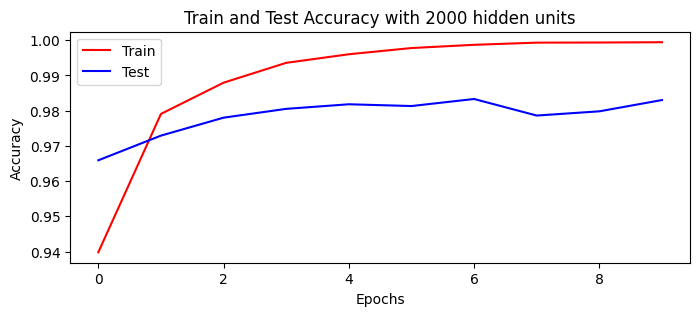

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8,3))
plt.plot([i for i in range(10)], train_accuracy_final[0], color = 'red', label = 'Train')
plt.plot([i for i in range(10)], test_accuracy_final[0], color = 'blue', label = 'Test')
plt.title('Train and Test Accuracy with 2000 hidden units')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

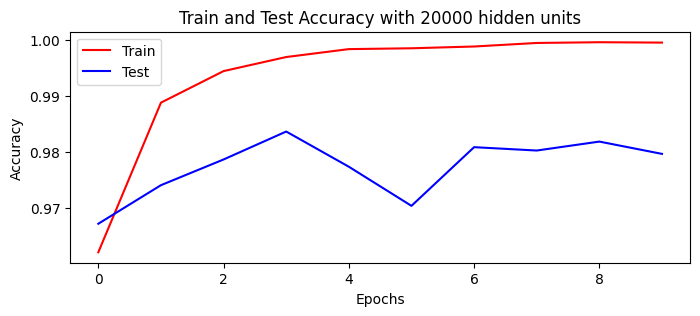

In [22]:
plt.figure(figsize = (8,3))
plt.plot([i for i in range(10)], train_accuracy_final[1], color = 'red', label = 'Train')
plt.plot([i for i in range(10)], test_accuracy_final[1], color = 'blue', label = 'Test')
plt.title('Train and Test Accuracy with 20000 hidden units')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

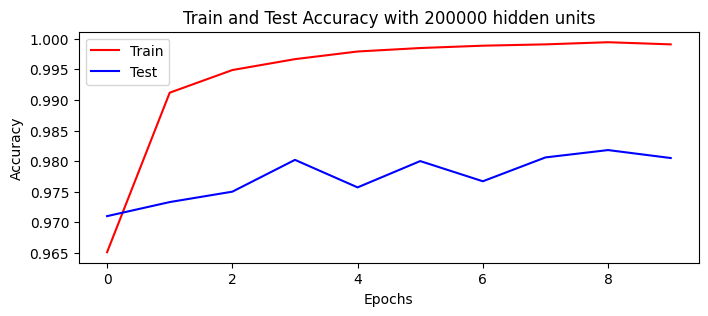

In [23]:
plt.figure(figsize = (8,3))
plt.plot([i for i in range(10)], train_accuracy_final[2], color = 'red', label = 'Train')
plt.plot([i for i in range(10)], test_accuracy_final[2], color = 'blue', label = 'Test')
plt.title('Train and Test Accuracy with 200000 hidden units')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

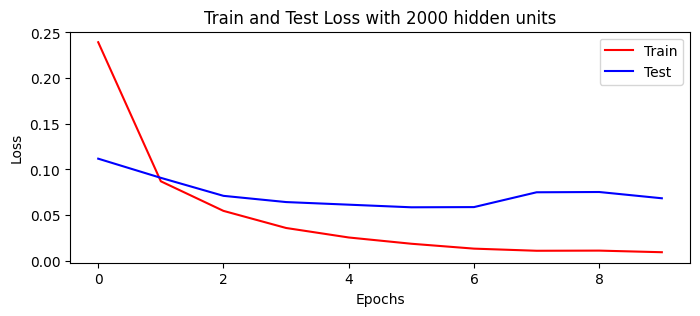

In [24]:
plt.figure(figsize = (8,3))
plt.plot([i for i in range(10)], train_loss_final[0], color = 'red', label = 'Train')
plt.plot([i for i in range(10)], test_loss_final[0], color = 'blue', label = 'Test')
plt.title('Train and Test Loss with 2000 hidden units')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

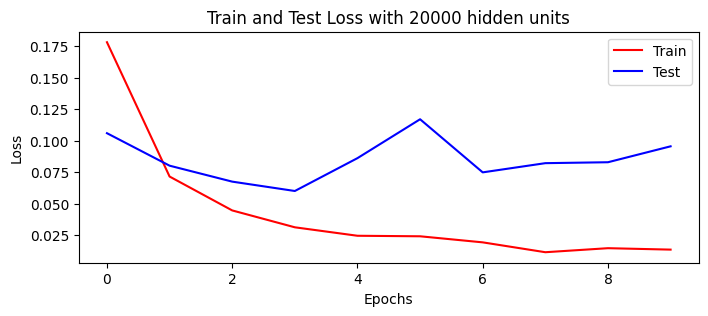

In [25]:
plt.figure(figsize = (8,3))
plt.plot([i for i in range(10)], train_loss_final[1], color = 'red', label = 'Train')
plt.plot([i for i in range(10)], test_loss_final[1], color = 'blue', label = 'Test')
plt.title('Train and Test Loss with 20000 hidden units')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

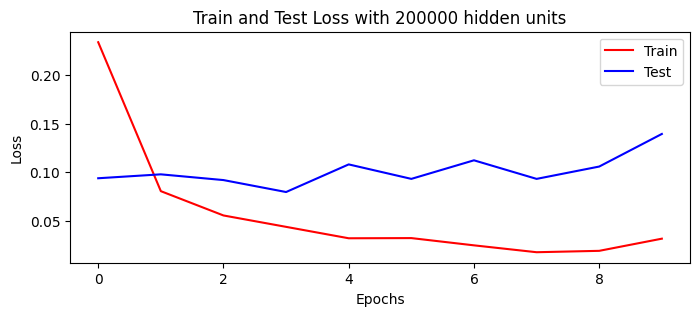

In [26]:
plt.figure(figsize = (8,3))
plt.plot([i for i in range(10)], train_loss_final[2], color = 'red', label = 'Train')
plt.plot([i for i in range(10)], test_loss_final[2], color = 'blue', label = 'Test')
plt.title('Train and Test Loss with 200000 hidden units')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()